# SC spike detection on MEA data
VR 2025-08-06

In [1]:
import retinanalysis as ra
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/riekelabbackup/Desktop/Vyom/RetinAnalysis/src/retinanalysis/classes/')
import raw
import importlib
importlib.reload(raw)

[2025-08-21 12:16:45,454][INFO]: DataJoint 0.14.4 connected to root@127.0.0.1:3306


<module 'raw' from '/Users/riekelabbackup/Desktop/Vyom/RetinAnalysis/src/retinanalysis/classes/raw.py'>

In [ ]:
# ra.populate_database()

Need to convert /Volumes/data-1/data/h5/20230706C.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/2023-07-13.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20231003C_old.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/test.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20240117C_old.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20240514C.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20220329C_mouse.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20220405C_mouse.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20240418C.h5 to json
going to implement this eventually
Need to convert /Volumes/data-1/data/h5/20240718C.h5 to json
going to implement this eventually
Need to convert /Volumes

Experiments:   0%|          | 0/136 [00:00<?, ?it/s]

Already in database: 20230406C
Already in database: 20230614C
Already in database: 20230629C
Already in database: 20230713C
Already in database: 20230719C
Already in database: 20240418H
Already in database: 20220406C
Already in database: 20220412C
Already in database: 20220420C
Already in database: 20220426C
Already in database: 20220518C
Already in database: 20220526C
Already in database: 20220531C
Already in database: 20220607C
Already in database: 20220705C
Already in database: 20220712C
Already in database: 20220726C
Already in database: 20220809C
Already in database: 20220816C
Already in database: 20220818C
Already in database: 20220823C
Already in database: 20220829C
Already in database: 20220909C
Already in database: 20221006C
Already in database: 20221024C
Already in database: 20221101C
Already in database: 20221114C
Already in database: 20221117C
Already in database: 20221123C
Already in database: 20221216C
Already in database: 20221219C
Already in database: 20221228C
Already 

  0%|          | 0/53 [00:00<?, ?it/s]

Found 13 text files in analysis directories.
There are now 386 entries in CellTypeFile.


In [ ]:
# ra.reload_celltypefiles(['20250814C'])

[2025-08-21 11:10:48,177][INFO]: Deleting 0 rows from `schema`.`cell_type_file`


Found 10 chunks for ['20250814C'].
Deleting associated 0 cell type files.
Finding CellTypeFile entries for each chunk...


  0%|          | 0/10 [00:00<?, ?it/s]

Found 1 text files in analysis directories.
There are now 387 entries in CellTypeFile.


In [4]:
ra.get_exp_summary('20250814C')

,exp_name,prep_label,datafile_name,group_label,NDF,chunk_name,protocol_name,duration_minutes,minutes_since_start,start_time,end_time,data_dir,experiment_id,prep_id,group_id,block_id,chunk_id,protocol_id
0,20250814C,Mount1,data000,CRF,0.5,chunk1,manookinlab.protocols.ContrastResponseGrating,1.20,1.20,2025-08-14 14:39:46,2025-08-14 14:40:58,20250814C/data000,148,169,2451,3635,569,1
1,20250814C,Mount1,data001,noise,0.5,chunk1,manookinlab.protocols.SpatialNoise,12.57,14.12,2025-08-14 14:41:19,2025-08-14 14:53:53,20250814C/data001,148,169,2452,3636,569,19
2,20250814C,Mount1,data002,noise,0.5,chunk1,manookinlab.protocols.SpatialNoise,49.48,65.60,2025-08-14 14:55:53,2025-08-14 15:45:22,20250814C/data002,148,169,2452,3637,569,19
3,20250814C,Mount1,data003,moving_bar,0.5,moving_bar,manookinlab.protocols.MovingChromaticBar,15.32,84.30,2025-08-14 15:48:45,2025-08-14 16:04:04,20250814C/data003,148,169,2453,3638,564,11
4,20250814C,Mount1,data004,doves perturbation,0.5,doves_perturb,edu.washington.riekelab.rachel.protocols.Doves...,59.70,160.03,2025-08-14 16:20:06,2025-08-14 17:19:48,20250814C/data004,148,169,2454,3639,568,69
5,20250814C,Mount1,data005,CRF,0.5,chunk2,manookinlab.protocols.ContrastResponseGrating,1.28,162.43,2025-08-14 17:20:55,2025-08-14 17:22:12,20250814C/data005,148,169,2455,3640,567,1
6,20250814C,Mount1,data006,120 Hz Big Noise,1.0,big_noise,manookinlab.protocols.SpatialNoise,40.80,209.88,2025-08-14 17:28:51,2025-08-14 18:09:39,20250814C/data006,148,169,2456,3641,561,19
7,20250814C,Mount1,data007,120 Hz Big Noise,1.0,big_noise,manookinlab.protocols.SpatialNoise,24.75,234.97,2025-08-14 18:09:59,2025-08-14 18:34:44,20250814C/data007,148,169,2456,3642,561,19
8,20250814C,Mount1,data008,noise,0.5,chunk2,manookinlab.protocols.SpatialNoise,34.18,271.33,2025-08-14 18:36:55,2025-08-14 19:11:06,20250814C/data008,148,169,2457,3643,567,19
9,20250814C,Mount1,data009,noise,0.5,chunk2,manookinlab.protocols.SpatialNoise,30.97,308.90,2025-08-14 19:17:42,2025-08-14 19:48:40,20250814C/data009,148,169,2457,3644,567,19


In [2]:
exp_name = '20250814C'
datafile_name = 'data004'
noise_chunk_name = 'chunk1'
pl = ra.create_mea_pipeline(exp_name, datafile_name, noise_chunk_name)

Initializing StimBlock for 20250814C block 3639
Nearest noise chunk for data004 is chunk1 with distance 35 minutes.

Initializing ResponseBlock for 20250814C block 3639
Keeping only 437 starts.
Assuming n_epochs = 437
Error occurred while getting actual onset/offset times: list index out of range
It could be that frame_times_ms do not have the correct number of frames due to some error in frame detection.
Check the frame monitor sample rate! On MEA Rigs, prefer 1k, errors likely with 10k.
Loading frame monitor data from /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/20250814C.h5 ...
Loaded (438, 70000) frame_data.

Loading VCD from /Volumes/Vyom MEA/analysis/20250814C/data004/kilosort2.5 ...
VCD loaded with 690 cells.

Loading VCD from /Volumes/Vyom MEA/analysis/20250814C/chunk1/kilosort2.5 ...
VCD loaded with 822 cells.

Loaded spatial maps for channels [0, 2] and 822 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.

Cluster matching 20

In [3]:
pl.export_to_pkl(f'/Volumes/data-1/data/sorted/20250814C/data004/{exp_name}_{datafile_name}_{noise_chunk_name}_pipeline.pkl')

MEAPipeline exported to /Volumes/data-1/data/sorted/20250814C/data004/20250814C_data004_chunk1_pipeline.pkl


In [4]:
test = ra.get_epochblock_timing(exp_name, 3639)
test.keys()

Assuming n_epochs = 437
Error occurred while getting actual onset/offset times: list index out of range
It could be that frame_times_ms do not have the correct number of frames due to some error in frame detection.


dict_keys(['exp_name', 'block_id', 'frameTimesMs', 'epochStarts', 'epochEnds', 'n_samples', 'n_epochs', 'pre_time_ms', 'stim_time_ms', 'tail_time_ms', 'stage_frame_rate', 'actual_onset_times_ms', 'actual_offset_times_ms'])

In [11]:
np.floor(test['pre_time_ms'] * test['stage_frame_rate'] * 1e-3), np.floor(test['stim_time_ms'] * test['stage_frame_rate'] * 1e-3)

(np.float64(29.0), np.float64(354.0))

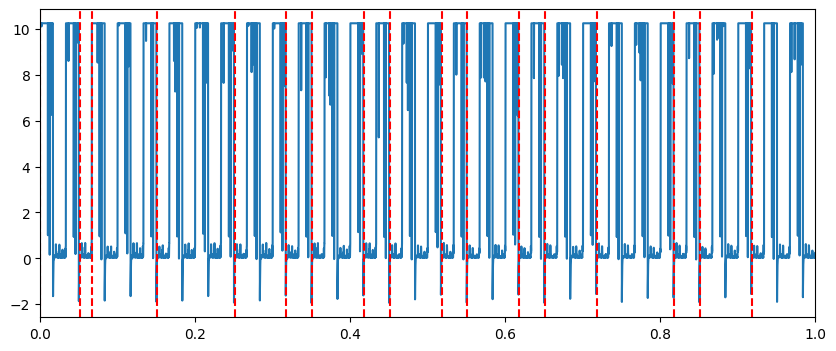

In [ ]:

plot_frame_monitor(pl.response_block, e_idx=0)

In [34]:
sts = [100, 500, 1200]
bin_rate = 1.0
n_bins = 2
time_bins = np.arange(n_bins+1)/bin_rate * 1000
bs = np.histogram(sts, bins=time_bins)[0]

In [35]:
time_bins

array([   0., 1000., 2000.])

In [36]:
bs

array([2, 1])

In [14]:
sb_actual = ra.StimBlock('20250527C', 3273)

Initializing StimBlock for 20250527C block 3273


In [6]:
sb0 = ra.StimBlock('2025-08-11_dpa_regen', 3548)
sb1 = ra.StimBlock('2025-08-11_dpa_regen', 3549)
sb2 = ra.StimBlock('2025-08-11_dpa_regen', 3550)

Initializing StimBlock for 2025-08-11_dpa_regen block 3548
Initializing StimBlock for 2025-08-11_dpa_regen block 3549
Initializing StimBlock for 2025-08-11_dpa_regen block 3550


In [15]:
sb_actual.df_epochs.at[0,'epoch_parameters']

{'NDF': 0.5,
 'amp': 'Amp1',
 'gain': None,
 'ndfs': '[]',
 'preTime': 500.0,
 'gridSize': 30.0,
 'stimTime': 6000.0,
 'tailTime': 500.0,
 'frameRate': 59.0,
 'imageName': 'imk00031.iml',
 'lightPath': 'below',
 'noiseSeed': 1.0,
 'noiseStdv': 0.3,
 'prerender': 0,
 'canvasSize': [1824.0, 1140.0],
 'frameDwell': 1.0,
 'numChecksX': 103.0,
 'numChecksY': 63.0,
 'pairedBars': 1,
 'sampleRate': 1000.0,
 'stixelSize': 60.0,
 'binaryNoise': 1,
 'subjectName': 'ACB2.eye',
 'centerOffset': [0.0, 0.0],
 'dataFileName': '20250527C\\data006.bin',
 'useFixedSeed': 0,
 'num_fixations': 11.0,
 'stimulusIndex': 2.0,
 'onlineAnalysis': 'none',
 'trueCanvasSize': [912.0, 1140.0],
 'micronsPerPixel': 3.37,
 'numMaxFixations': 10.0,
 'stimulusIndices': [2.0, 10.0, 15.0, 24.0],
 'apertureDiameter': 0.0,
 'numberOfAverages': 150,
 'interpulseInterval': 0.5,
 'monitorRefreshRate': 59.0,
 'backgroundIntensity': 0.35362239121041844,
 'expectedRefreshRate': 59.94,
 'manualMagnification': 1.5,
 'imgContrastRed

In [9]:
sb0.df_epochs.at[0,'epoch_parameters']

{'amp': 'Amp1',
 'gain': None,
 'ndfs': '[]',
 'preTime': 500.0,
 'gridSize': 30.0,
 'stimTime': 6000.0,
 'tailTime': 500.0,
 'frameRate': 60.0,
 'imageName': 'imk00031.iml',
 'noiseSeed': 2379168226.0,
 'frameDwell': 1.0,
 'numChecksX': 42.0,
 'numChecksY': 30.0,
 'pairedBars': 0,
 'sampleRate': 10000.0,
 'stixelSize': 60.0,
 'binaryNoise': 1,
 'subjectName': 'ACB2.eye',
 'noiseOpacity': 0.3,
 'useFixedSeed': 1,
 'num_fixations': 11.0,
 'stimulusIndex': 2.0,
 'onlineAnalysis': 'none',
 'numMaxFixations': 10.0,
 'stimulusIndices': [2.0, 10.0],
 'apertureDiameter': 0.0,
 'numberOfAverages': 2,
 'interpulseInterval': 0.5,
 'backgroundIntensity': 0.35362239121049094,
 'manualMagnification': 1.5,
 'imgContrastReduction': 0.10608671736314727}

In [7]:
sb0.export_to_pkl('/Volumes/Vyom MEA/data/samarjit_datajoint/regen_files/sb0.pkl')
sb1.export_to_pkl('/Volumes/Vyom MEA/data/samarjit_datajoint/regen_files/sb1.pkl')
sb2.export_to_pkl('/Volumes/Vyom MEA/data/samarjit_datajoint/regen_files/sb2.pkl')

StimBlock exported to /Volumes/Vyom MEA/data/samarjit_datajoint/regen_files/sb0.pkl

StimBlock exported to /Volumes/Vyom MEA/data/samarjit_datajoint/regen_files/sb1.pkl

StimBlock exported to /Volumes/Vyom MEA/data/samarjit_datajoint/regen_files/sb2.pkl



In [2]:
exp_name = '20250306C'
datafile_name = 'data026'
ss_version = 'vision'
vs_mpl = ra.create_mea_pipeline(exp_name, datafile_name, 'chunk4', rb_ss_version=ss_version)
ks_mpl = ra.create_mea_pipeline(exp_name, datafile_name, 'chunk4')

Initializing StimBlock for 20250306C block 3158
Nearest noise chunk for data026 is chunk4 with distance 29 minutes.

Initializing ResponseBlock for 20250306C block 3158
For 20250306C block 3158:
Set pre_time_ms=250.0, stim_time_ms=57500.0, tail_time_ms=250.0
Delivered pre_frames=14, stim_frames=3392
Actual onset times (ms): [234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0]
Actual offset times (ms): [56822.0, 56822.0, 56822.0, 56822.0, 56822.0, 56822.0, 56822.0, 56822.0, 56822.0, 56822.0]
Loading frame monitor data from /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/20250306C.h5 ...
Loaded (10, 580000) frame_data.

Loading VCD from /Volumes/Vyom MEA/analysis/20250306C/data026/vision ...
VCD loaded with 256 cells.

Loading VCD from /Volumes/Vyom MEA/analysis/20250306C/chunk4/kilosort2.5 ...
VCD loaded with 534 cells.

Loaded spatial maps for channels [0, 2] and 534 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.

Clus

In [3]:
target_ks_id = 480
for ac_id, ks_rb_id in ks_mpl.match_dict.items():
    if ks_rb_id == target_ks_id:
        print(f"Found matching ks_rb_id {ks_rb_id} for ac_id {ac_id}")
        target_ac_id = ac_id
vs_rb_id = vs_mpl.match_dict[target_ac_id]
print(f"Corresponding vs_rb_id: {vs_rb_id}")

Found matching ks_rb_id 480 for ac_id 279
Corresponding vs_rb_id: 3336


<Axes: xlabel='cell_type', ylabel='n_matches'>

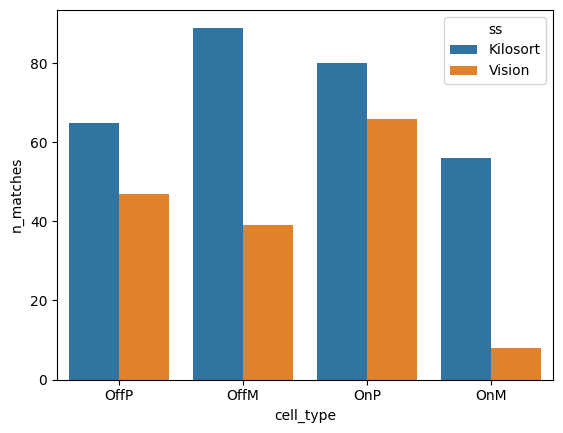

In [4]:
# Plot summary of matched cells of major types
import pandas as pd
import seaborn as sns
ls_types = ['OffP', 'OffM', 'OnP', 'OnM']
d_summary = {'cell_type': [], 'n_matches': [], 'ss': []}
for cell_type in ls_types:
    n_ks_matches = len(ks_mpl.get_noise_ids(cell_types=[cell_type]))
    n_vs_matches = len(vs_mpl.get_noise_ids(cell_types=[cell_type]))
    d_summary['cell_type'].append(cell_type)
    d_summary['n_matches'].append(n_ks_matches)
    d_summary['ss'].append('Kilosort')
    d_summary['cell_type'].append(cell_type)
    d_summary['n_matches'].append(n_vs_matches)
    d_summary['ss'].append('Vision')
df_summary = pd.DataFrame(d_summary)
sns.barplot(data=df_summary, x='cell_type', y='n_matches', hue='ss')

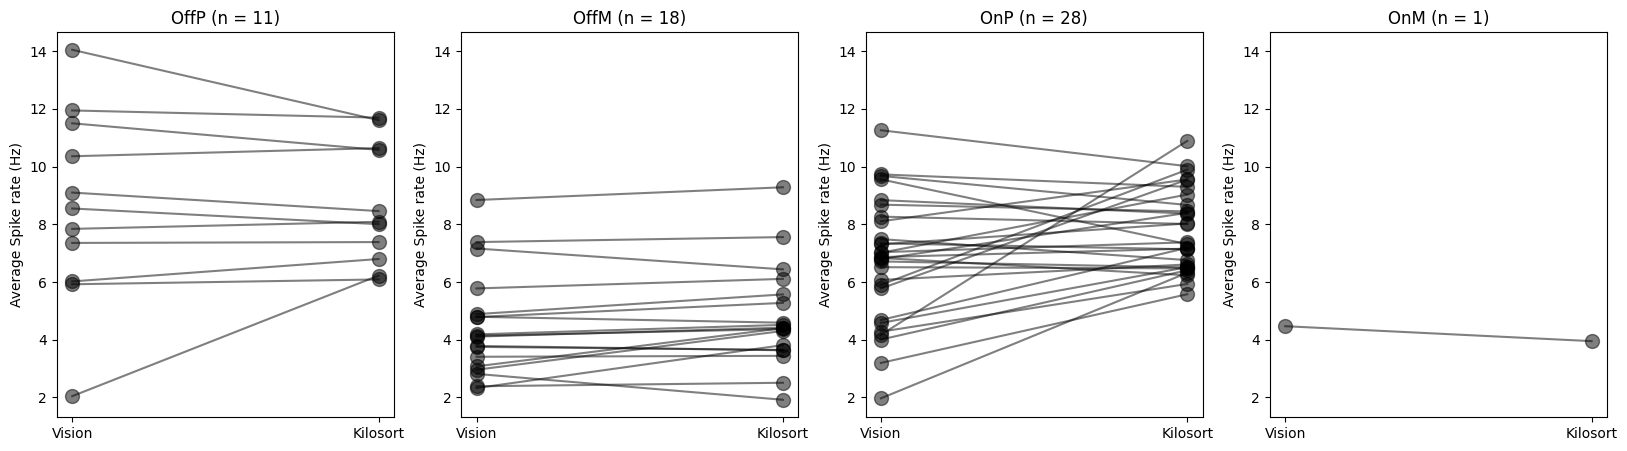

In [8]:
ks_mpl.add_types_to_protocol(typing_file='qc_vr_kilosort2.5.classification.txt' )
vs_mpl.add_types_to_protocol(typing_file='qc_vr_kilosort2.5.classification.txt' )



f, axs = plt.subplots(figsize=(20,5), ncols=4, sharey=True)
for i, str_type in enumerate(ls_types):
    ax = axs[i]
    type_ids = ks_mpl.get_noise_ids(cell_types=[str_type])
    # for ac_id, rb_id in mpl.match_dict.items():
    found_type_ids = []
    for ac_id in type_ids:
    # for ac_id in [target_ac_id]:
        if ac_id not in ks_mpl.match_dict or ac_id not in vs_mpl.match_dict:
            # type_ids.remove(ac_id)
            continue
        vs_rb_id = vs_mpl.match_dict[ac_id]
        ks_rb_id = ks_mpl.match_dict[ac_id]
        found_type_ids.append(ac_id)



        cell_idx = np.where(vs_mpl.response_block.df_spike_times['cell_id']==vs_rb_id)[0][0]
        vs_sts = vs_mpl.response_block.df_spike_times.at[cell_idx, 'spike_times']
        n_sps_vision = np.mean([len(st)/max(st)*1e3 for st in vs_sts])

        cell_idx = np.where(ks_mpl.response_block.df_spike_times['cell_id']==ks_rb_id)[0][0]
        ks_sts = ks_mpl.response_block.df_spike_times.at[cell_idx, 'spike_times']
        n_sps_ks = np.mean([len(st)/max(st)*1e3 for st in ks_sts])
        ax.plot([n_sps_vision, n_sps_ks], '-o', c='k', ms=10, alpha=0.5)
    ax.set_xticks([0, 1], ['Vision', 'Kilosort'])
    ax.set_ylabel('Average Spike rate (Hz)')
    ax.set_title(f'{str_type} (n = {len(found_type_ids)})')
    ax.yaxis.set_tick_params(labelleft=True)

In [7]:
importlib.reload(raw)
import os
str_parent_dir = '/Volumes/Vyom MEA/analysis/20250306C/data026/comparison'
rt = raw.RawTraces(ks_mpl.response_block)
# for epoch_idx in range(ks_mpl.response_block.n_epochs):
epoch_idx = 0
rt.load_epoch_index(epoch_idx, verbose=True)

Number of electrodes: 512, Total samples: 13140000.
Total time: 657.0 seconds
Sample rate: 20000 Hz
Querying 1159956 samples from 62332 to 1222288.
Queried time: 57.9978 seconds
From 3.1166 to 61.1144 seconds
Data shape: (512, 1159956)


In [ ]:
import tqdm
def plot_vision_vs_ks(rt, ks_rb, vs_rb, ks_id, vs_id, epoch_idx, str_save_dir):
    top_idx = ra.ei_utils.get_top_electrodes(ks_id, ks_rb.vcd, n_markers=1, b_sort=False)[0]
    channel_idx = rt.sorted_electrodes[top_idx]
    print(f'Channel index: {channel_idx}, Kilosort ID: {ks_id}, Vision ID: {vs_id}, Epoch index: {epoch_idx}')

    delta_time = 0.3
    start_times = np.arange(0.25, 20.3, delta_time)
    end_times = start_times + delta_time
    for i in tqdm.trange(len(start_times)):
        start_time = start_times[i]
        end_time = end_times[i]

        f, axs = plt.subplots(nrows=2, figsize=(12, 4))
        raw.plot_sts_over_trace(rt, ks_rb, ks_id, epoch_idx,
        start_time=start_time, end_time=end_time, channel_idx=channel_idx, ax=axs[0])
        raw.plot_sts_over_trace(rt, vs_rb, vs_id, epoch_idx,
        start_time=start_time, end_time=end_time, channel_idx=channel_idx, ax=axs[1])
        axs[0].set_title(f'Kilosort ID {ks_id}')
        axs[1].set_title(f'Vision matched ID {vs_id}')
        plt.tight_layout()
        
        if str_save_dir is not None:
            str_save_path = os.path.join(str_save_dir, f'epoch_{epoch_idx}_start_{start_time:.2f}_end_{end_time:.2f}.png')
            plt.savefig(str_save_path, bbox_inches='tight')
            plt.close()

Channel index: 19, Kilosort ID: 50, Vision ID: 348, Epoch index: 0
Channel index: 36, Kilosort ID: 101, Vision ID: 545, Epoch index: 0
Channel index: 58, Kilosort ID: 171, Vision ID: 828, Epoch index: 0
Channel index: 55, Kilosort ID: 174, Vision ID: 949, Epoch index: 0
Channel index: 91, Kilosort ID: 292, Vision ID: 1369, Epoch index: 0


KeyboardInterrupt: 

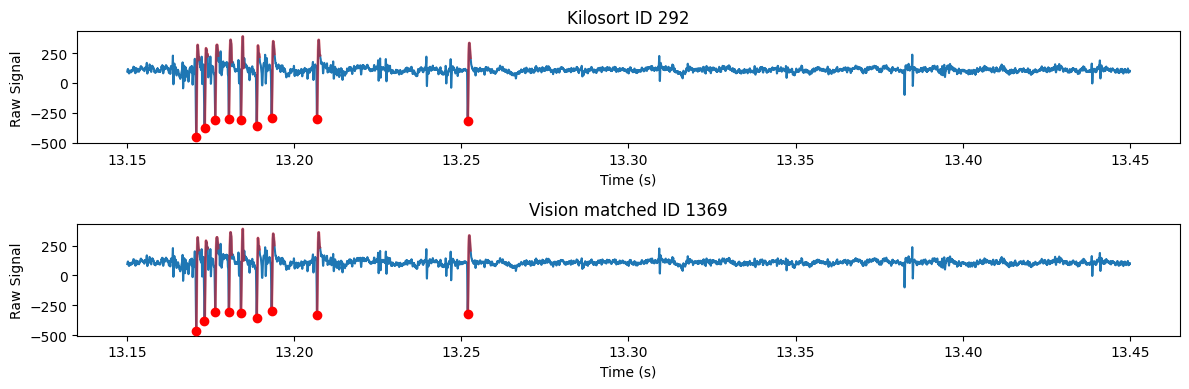

In [51]:
epoch_idx = 0
for ac_id in type_ids:
    # ac_id = target_ac_id
    str_save_dir = os.path.join(str_parent_dir, f'{str_type}_{ac_id}')
    os.makedirs(str_save_dir, exist_ok=True)
    ks_rb_id = ks_mpl.match_dict[ac_id]
    vs_rb_id = vs_mpl.match_dict[ac_id]
    plot_vision_vs_ks(rt, ks_mpl.response_block, vs_mpl.response_block, ks_rb_id, vs_rb_id, epoch_idx, str_save_dir)

In [ ]:
import retinanalysis.utils.spike_detector as sd

In [34]:
# Run detector
str_save_dir = '/Volumes/Vyom MEA/analysis/20250306C/data026/turner_ss/480'
spike_times, amps, refs = sd.detector(
    raw_ts[np.newaxis, :], sample_rate=rt.sample_rate,
    n_clusters=2, 
    max_trial_length_s=2, min_peak_amplitude=200)#, 
    # check_detection=True, str_save_dir=str_save_dir)

Max trial length in data points: 40000 = 2 s
Trial 1: Found 193794 peaks
Trial 1: Splitting data into 29 sections for KMeans clustering.
Trial 1: Found 2862 spikes
Rejected 1656/2862 spikes with amplitude < 200.00 peak amp.
Trial 1: 57 refractory violations


(5.15, 5.4)

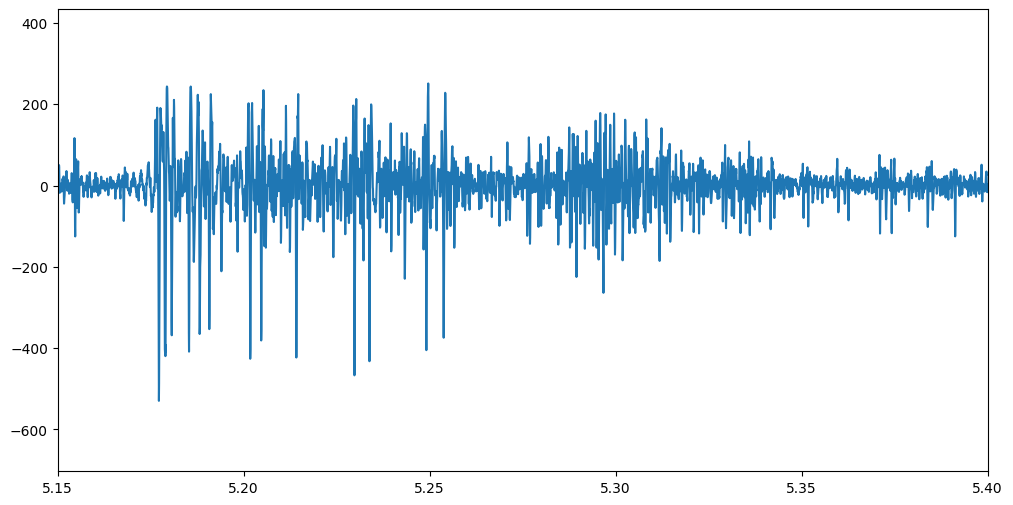

In [33]:
test = sd.high_pass_filter(raw_ts[np.newaxis, :], 500, 1/rt.sample_rate)

f, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, test[0])
ax.set_xlim(5.15,5.4)

(5.15, 5.4)

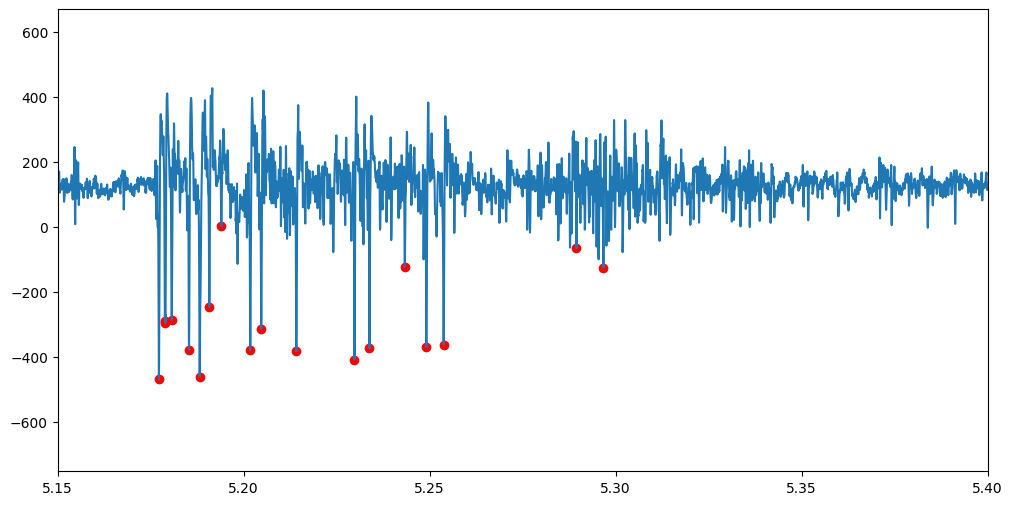

In [35]:
f, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, raw_ts)
ax.scatter(time[spike_times[0]], raw_ts[spike_times[0]], color='red')
ax.set_xlim(5.15,5.4)